In [1]:
import pandas as pd
import numpy as np

In [2]:
from kaggle.api.kaggle_api_extended import KaggleApi

dataset = 'blastchar/telco-customer-churn'
path = 'datasets/churn'

api = KaggleApi()
api.authenticate()
api.dataset_download_files(dataset, path=path, unzip=True)

In [3]:
from glob import glob # recursive wildcard pattern
import pandas as pd

df = pd.read_csv(glob(f'{path}/*.csv')[0])

# Part I. 사전 데이터 분석

In [5]:
df.info() # 현재 feature들을 거의 그대로 쓸 예정

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


| Column            | Dtype   | 한글 설명          |
|-------------------|---------|-------------------|
| customerID        | object  | 고객 ID           |
| gender            | object  | 성별              |
| SeniorCitizen     | int64   | 고령자 여부       |
| Partner           | object  | 파트너 여부       |
| Dependents        | object  | 부양 가족 여부    |
| tenure            | int64   | 가입 기간(월) - 시작과 끝을 알 수 없음    |
| PhoneService      | object  | 전화 서비스 가입 여부 |
| MultipleLines     | object  | 다중 회선 사용 여부 |
| InternetService   | object  | 인터넷 서비스 종류 |
| OnlineSecurity    | object  | 온라인 보안 서비스 가입 여부 |
| OnlineBackup      | object  | 온라인 백업 서비스 가입 여부 |
| DeviceProtection  | object  | 기기 보호 서비스 가입 여부 |
| TechSupport       | object  | 기술 지원 서비스 가입 여부 |
| StreamingTV       | object  | TV 스트리밍 서비스 가입 여부 |
| StreamingMovies   | object  | 영화 스트리밍 서비스 가입 여부 |
| Contract          | object  | 계약 유형         |
| PaperlessBilling  | object  | 무페이퍼 청구서 여부 |
| PaymentMethod     | object  | 결제 방법         |
| MonthlyCharges    | float64 | 월 청구 금액      |
| TotalCharges      | object  | 총 청구 금액      |
| Churn             | object  | 이탈 여부         |


### 필드 성격의 종류
- 개인정보 및 가족구성
- 서비스 가입 여부
- 계약 형태
- 결제 관련

#### Plotly를 이용한 시각화
- [Plotly](https://plotly.com/python/)

In [11]:
#!pip install plotly # 동적 화면 구성 가능

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 20.3 MB/s eta 0:00:0000:0100:01


### 기초데이터 확인

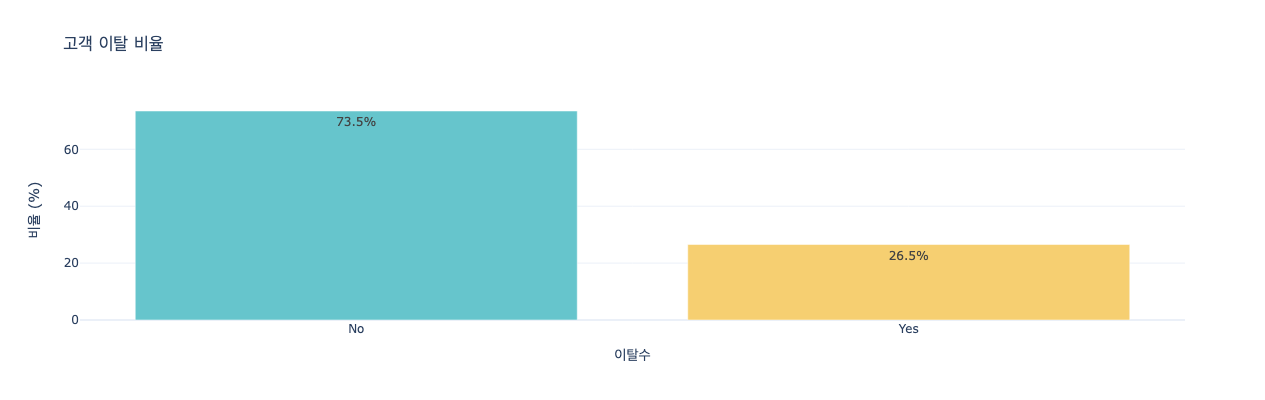

In [6]:
import plotly.express as px

churn_rate = (df['Churn'].value_counts(normalize=True) * 100)
churn_rate_str = churn_rate.map('{:0.1f}%'.format)

fig = px.bar(churn_rate, x=churn_rate.index, y=churn_rate.values, labels={'y':'비율 (%)', 'index':'Churn'},
             title='고객 이탈 비율', text=churn_rate_str,
             color=churn_rate.index, color_discrete_sequence=px.colors.qualitative.Pastel, template='plotly_white', width=400, height=400)
fig.update_layout(xaxis_title='이탈수', yaxis_title='비율 (%)', showlegend=False)
fig.show()

/tmp/ipykernel_177/3217165142.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



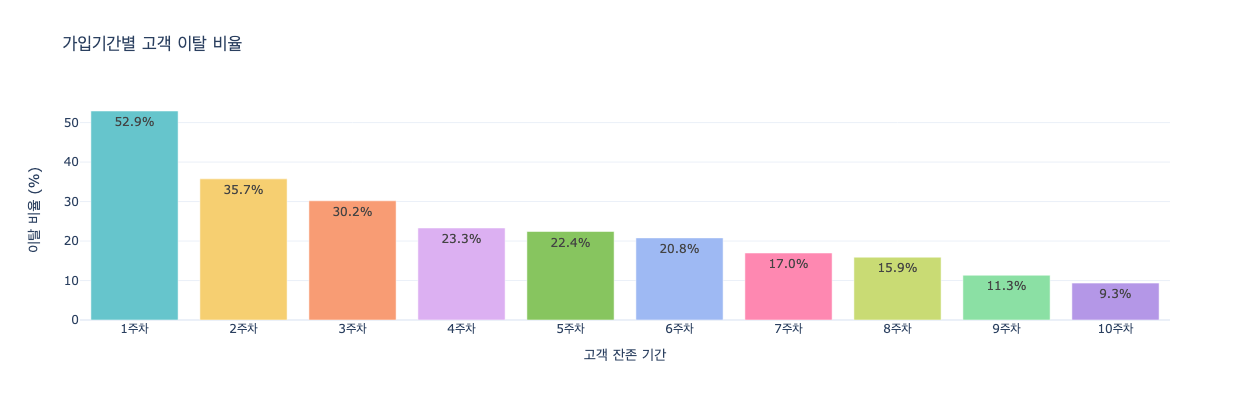

In [7]:
# 가입기간별 이탈 비율 시각화(7일 단위)
df['tenure_group'] = pd.cut(df['tenure'], bins=range(0, 73, 7), right=False) # 7일씩 끊어서 주차별로 확인하기 위해 정리 (bins = range(0,73,7)
# 'tenure_group' 열의 데이터 타입을 문자열로 변환합니다.
df['tenure_group_str'] = df['tenure_group'].apply(lambda x: f'{(x.left // 7) + 1}주차')
# 'Churn' 열의 데이터 타입을 숫자로 변환합니다. 'Yes'는 1로, 'No'는 0으로 매핑합니다.
df['Churn_numeric'] = df['Churn'].map({'Yes': 1, 'No': 0})
# 이제 'Churn_numeric' 열을 사용하여 평균을 계산합니다.
churn_rate = df.groupby('tenure_group_str')['Churn_numeric'].mean() * 100
churn_rate_str = churn_rate.map('{:0.1f}%'.format)

fig = px.bar(churn_rate, x=churn_rate.index, y=churn_rate.values, labels={'y':'이탈 비율 (%)', 'index':'고객 잔존 기간'},
                title='가입기간별 고객 이탈 비율', text=churn_rate_str,
                
                color=churn_rate.index, color_discrete_sequence=px.colors.qualitative.Pastel, template='plotly_white', width=800, height=400)
fig.update_layout(xaxis_title='고객 잔존 기간', yaxis_title='이탈 비율 (%)', showlegend=False)
fig.show()


### 결과 확인
* 가입기간이 길수록 y값이 row(low?)에 가깝다.

## 결제관련 탐색

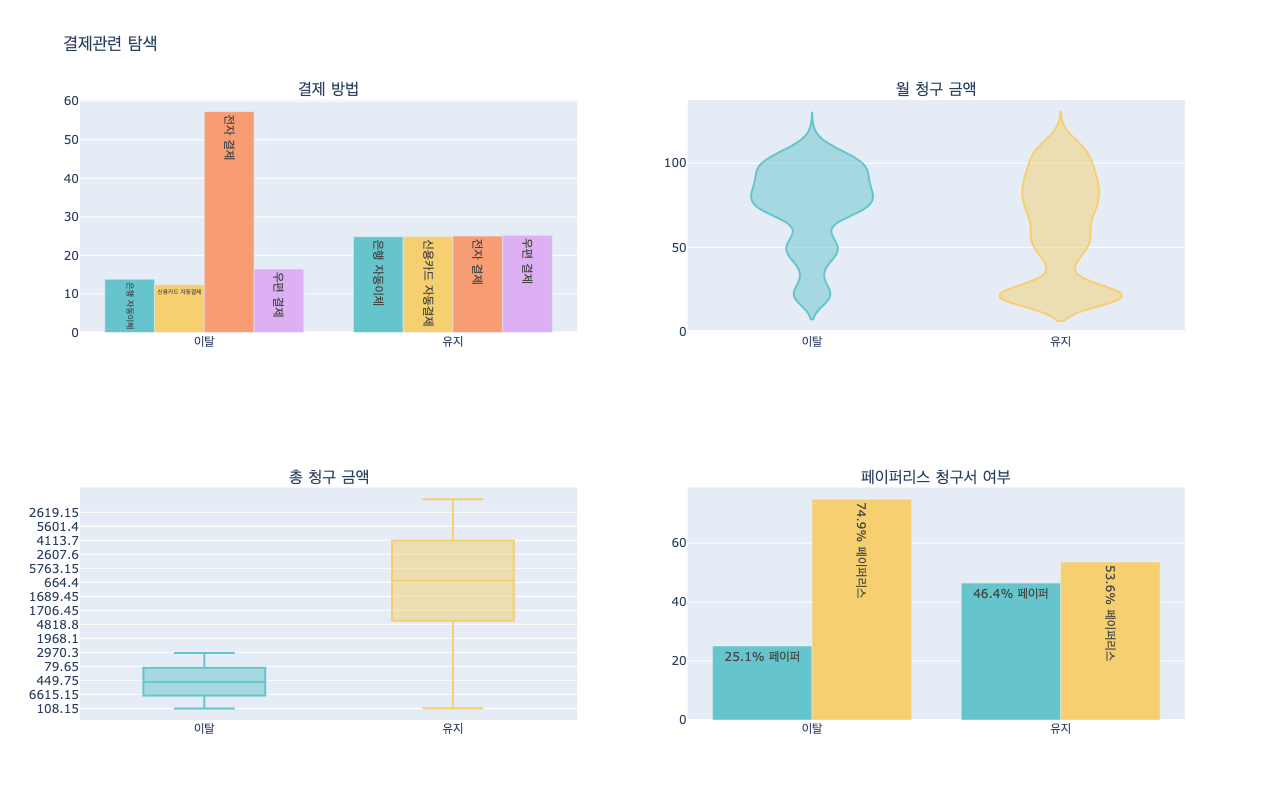

In [8]:
# 결제 방법, 월 청구 금액, 총 청구 금액, 페이퍼리스 청구서 여부 4개 필드를 churn 여부에 따라 분포를 2x2로 그래프로 표현

from plotly.subplots import make_subplots
import plotly.graph_objects as go

# 2x2 캔버스 생성
fig = make_subplots(rows=2, cols=2, subplot_titles=("결제 방법", "월 청구 금액", "총 청구 금액", "페이퍼리스 청구서 여부"))
# 결제 방법 분포
payment_method_translations ={
    'Electronic check': '전자 결제', 
    'Mailed check': '우편 결제', 
    'Bank transfer (automatic)': '은행 자동이체',
    'Credit card (automatic)': '신용카드 자동결제'
} 
payment_method = df.groupby('Churn')['PaymentMethod'].value_counts(normalize=True).unstack().fillna(0) * 100
payment_method = payment_method.iloc[::-1]
colors = px.colors.qualitative.Pastel
for i, method in enumerate(payment_method.columns):
    fig.add_trace(go.Bar(x=payment_method.index.map(lambda x: '이탈' if x == 'Yes' else '유지'), y=payment_method[method], name=payment_method_translations[method], marker_color=colors[i % len(colors)], text=payment_method_translations[method], textposition='auto'), row=1, col=1)
# 월 청구 금액 분포
monthly_charges = df.groupby('Churn')['MonthlyCharges']
fig.add_trace(go.Violin(y=monthly_charges.get_group('Yes'), name='이탈', line_color=colors[0]), row=1, col=2)
fig.add_trace(go.Violin(y=monthly_charges.get_group('No'), name='유지', line_color=colors[1]), row=1, col=2)
# 총 청구 금액 분포
total_charges = df.groupby('Churn')['TotalCharges']
fig.add_trace(go.Box(y=total_charges.get_group('Yes'), name='이탈', marker_color=colors[0]), row=2, col=1)
fig.add_trace(go.Box(y=total_charges.get_group('No'), name='유지', marker_color=colors[1]), row=2, col=1)
# 무페이퍼 청구서 여부 분포
paperless_billing = df.groupby('Churn')['PaperlessBilling'].value_counts(normalize=True).unstack().fillna(0) * 100
paperless_billing = paperless_billing.iloc[::-1]
for i, status in enumerate(paperless_billing.columns):
    fig.add_trace(go.Bar(
        x=paperless_billing.index.map(lambda x: '이탈' if x == 'Yes' else '유지'), 
        y=paperless_billing[status], 
        name="페이퍼리스" if status == 'Yes' else "페이퍼", 
        text=paperless_billing[status].map(lambda x: "{:0.1f}% 페이퍼리스".format(x) if status == 'Yes' else "{:0.1f}% 페이퍼".format(x)),
        marker_color=colors[i % len(colors)]), row=2, col=2)
# 그래프 업데이트
fig.update_layout(height=800, width=1200, title_text="결제관련 탐색")

# 범례 제거
fig.update_layout(showlegend=False)
fig.show()


### 결제 관련 1차 분석 결과 알게된 사실
* 전자 결제를 하는 사람이 이탈 가능성 월등히 높다. (가설 : 쉬운 탈퇴UX 제공이 이탈을 유도하는 요인일 수 있다.)
* 페이퍼리스 청구서를 받는 사람이 이탈 가능성이 높다. (가설 : 페이퍼리스 청구서는 소비지출 인식을 쉽게 하기 때문에 이탈 가능성이 높다.)
* 월 청구 금액이 높을 수록 이탈 가능성이 높다. (가설: 이미 월청구금액을 낮게 조정한 사람은 계속 이용하고자 하는 의지가 강할 것이다.)
* 조기 이탈에 따른 영향으로 총 청구금액은 이탈자가 당연히 낮게 나타난다.

### 추가로 알아볼 사항
* 결제 방법 및 페이퍼리스 청구서 여부 별로 월 청구금액의 분포
* 결제 방법과 페이퍼리스 청구서 수신 여부의 상관관계
* 각 항목의 범주형 통계가 유의미한지 확인

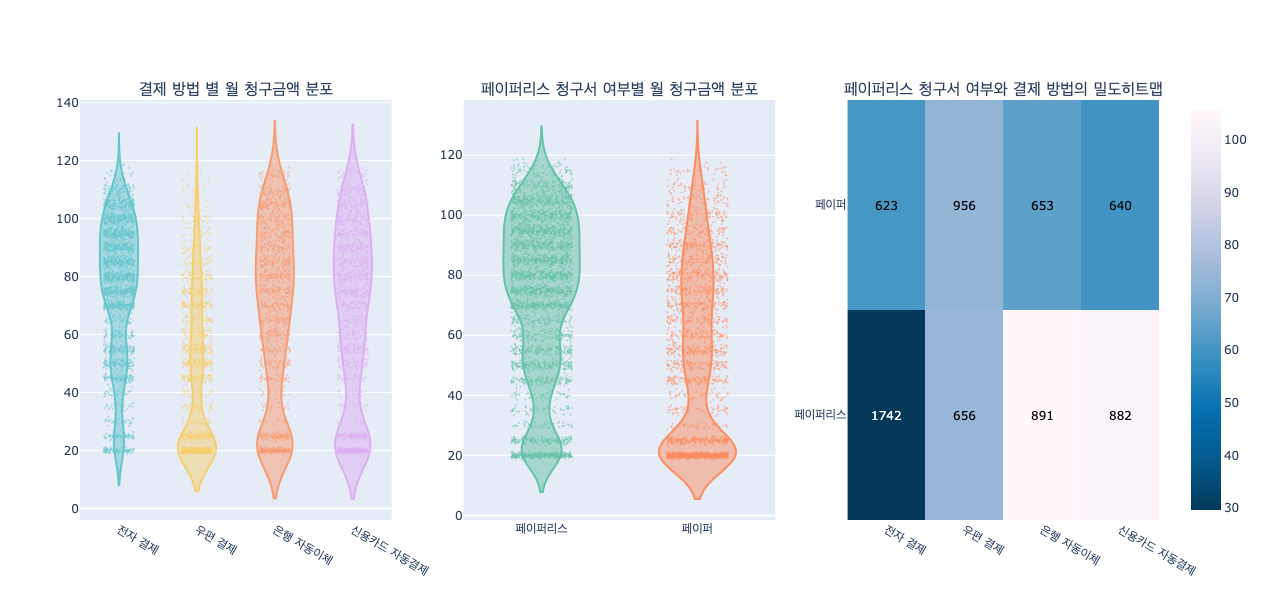

In [9]:
# 결제 방법 별로 월 청구금액의 분포 및 페이퍼리스 청구서 여부별 월 청구금액의 분포
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=3, subplot_titles=("결제 방법 별 월 청구금액 분포", "페이퍼리스 청구서 여부별 월 청구금액 분포", "페이퍼리스 청구서 여부와 결제 방법의 밀도히트맵"))

colors = px.colors.qualitative.Pastel
for i, method in enumerate(df['PaymentMethod'].unique()):
    fig.add_trace(go.Violin(y=df[df['PaymentMethod'] == method]['MonthlyCharges'], 
                            name=payment_method_translations[method], 
                            line_color=colors[i % len(colors)],
                            points="all",
                            pointpos=0,
                            jitter=0.8,
                            marker=dict(opacity=0.5, size=2)), row=1, col=1)

colors = px.colors.qualitative.Set2
for i, status in enumerate(df['PaperlessBilling'].unique()):
    fig.add_trace(go.Violin(y=df[df['PaperlessBilling'] == status]['MonthlyCharges'], 
                            name="페이퍼리스" if status == 'Yes' else "페이퍼", 
                            line_color=colors[i % len(colors)],
                            points="all",
                            pointpos=0,
                            jitter=0.8,
                            marker=dict(opacity=0.5, size=2)), row=1, col=2)
# density heatmap  
colors = px.colors.sequential.PuBu_r
fig.add_trace(go.Heatmap(x=df['PaymentMethod'], y=df['PaperlessBilling'], z=df['MonthlyCharges'], colorscale=colors), row=1, col=3)
fig.update_xaxes(tickvals=list(payment_method_translations.keys()), ticktext=list(payment_method_translations.values()), row=1, col=3)
fig.update_yaxes(tickvals=['Yes', 'No'], ticktext=['페이퍼리스', '페이퍼'], row=1, col=3)
# 각 셀에 대한 개수를 표시하는 annotation 추가
for i, row in enumerate(df['PaymentMethod'].unique()):
    for j, col in enumerate(df['PaperlessBilling'].unique()):
        count = len(df[(df['PaymentMethod'] == row) & (df['PaperlessBilling'] == col)])
        # 1000 이하는 검은색으로 표시
        font_color = "black" if count <= 1000 else "white"
        fig.add_annotation(x=i, y=j, text=str(count), showarrow=False, font=dict(color=font_color), row=1, col=3)



fig.update_layout(height=600, width=1500, showlegend=False)
fig.show()


In [10]:
# 결제 방법, 페이퍼리스청구서여부의 이탈 여부의 통계적 유의성을 검정
from scipy.stats import chi2_contingency

# 이탈 여부에 따른 특성별 카이제곱 검정
def chi2_test(df, feature):
    crosstab = pd.crosstab(df['Churn'], df[feature])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    return chi2, p

chi_result = chi2_test(df, 'PaymentMethod'), chi2_test(df, 'PaperlessBilling')

# 카이제곱 검정 결과 출력
for i, feature in enumerate(['PaymentMethod', 'PaperlessBilling']):
    print(f'{feature}에 대한 카이제곱 검정 결과')
    print(f'  chi2: {chi_result[i][0]:.2f}')
    print(f'  p-value: {chi_result[i][1]:.2f}')
    if chi_result[i][1] < 0.05:
        print('  => 유의미한 결과: 이탈 여부에 영향을 미침')
    else:
        print('  => 유의미하지 않은 결과: 이탈 여부에 영향을 미치지 않음')
    print()
    


PaymentMethod에 대한 카이제곱 검정 결과
  chi2: 648.14
  p-value: 0.00
  => 유의미한 결과: 이탈 여부에 영향을 미침

PaperlessBilling에 대한 카이제곱 검정 결과
  chi2: 258.28
  p-value: 0.00
  => 유의미한 결과: 이탈 여부에 영향을 미침



In [11]:
# 결제 방법, 페이퍼리스청구서여부 별로 월 청구금액 분포에 유의한 차이가 있는지 t-검정
from scipy.stats import ttest_ind # 한 쪽이 연속형일 때, T-test 진행

# 두 집단 간의 평균 차이를 검정하는 t-검정
def t_test(df, feature):
    group1 = df[df[feature] == df[feature].unique()[0]]['MonthlyCharges']
    group2 = df[df[feature] == df[feature].unique()[1]]['MonthlyCharges']
    t, p = ttest_ind(group1, group2)
    return t, p

t_result = t_test(df, 'PaymentMethod'), t_test(df, 'PaperlessBilling')

# t-검정 결과 출력

for i, feature in enumerate(['PaymentMethod', 'PaperlessBilling']):
    print(f'{feature}에 대한 t-검정 결과')
    print(f'  t: {t_result[i][0]:.2f}')
    print(f'  p-value: {t_result[i][1]:.2f}')
    if t_result[i][1] < 0.05:
        print('  => 유의미한 결과: 월 청구금액에 차이가 존재함')
    else:
        print('  => 유의미하지 않은 결과: 월 청구금액에 차이가 존재하지 않음')
    print()
    

PaymentMethod에 대한 t-검정 결과
  t: 40.06
  p-value: 0.00
  => 유의미한 결과: 월 청구금액에 차이가 존재함

PaperlessBilling에 대한 t-검정 결과
  t: 31.57
  p-value: 0.00
  => 유의미한 결과: 월 청구금액에 차이가 존재함



### 결제 관련 2차 분석 결과 알게된 사실
* 전자결제와 페이퍼리스청구여부는 상관성이 높다 (추정 : 전자결제는 UX에서 페이퍼리스청구를 디폴트로 제공하는것으로 보인다. 비즈니스적 인사이트는 없음)
* 전자결제와 은행/카드 자동이체는 월결제금액이 다같이 높지만, 전자결제는 왜도가 높다. (가설 : 전자결제는 결제금액이 높은 상품을 선호하는 경향이 있을 수 있다.)
* 월결제금액의 분포로 봤을때, 낮은 결제금액상품과 높은 결제금액상품으로 이원화된 상품이 존재하는것으로 보인다. (추가확인해볼수 있는 사항 : 결제방법과 페이퍼리스청구 매트릭스별로 월청구금액의 분포)

## 가족 구성 탐색

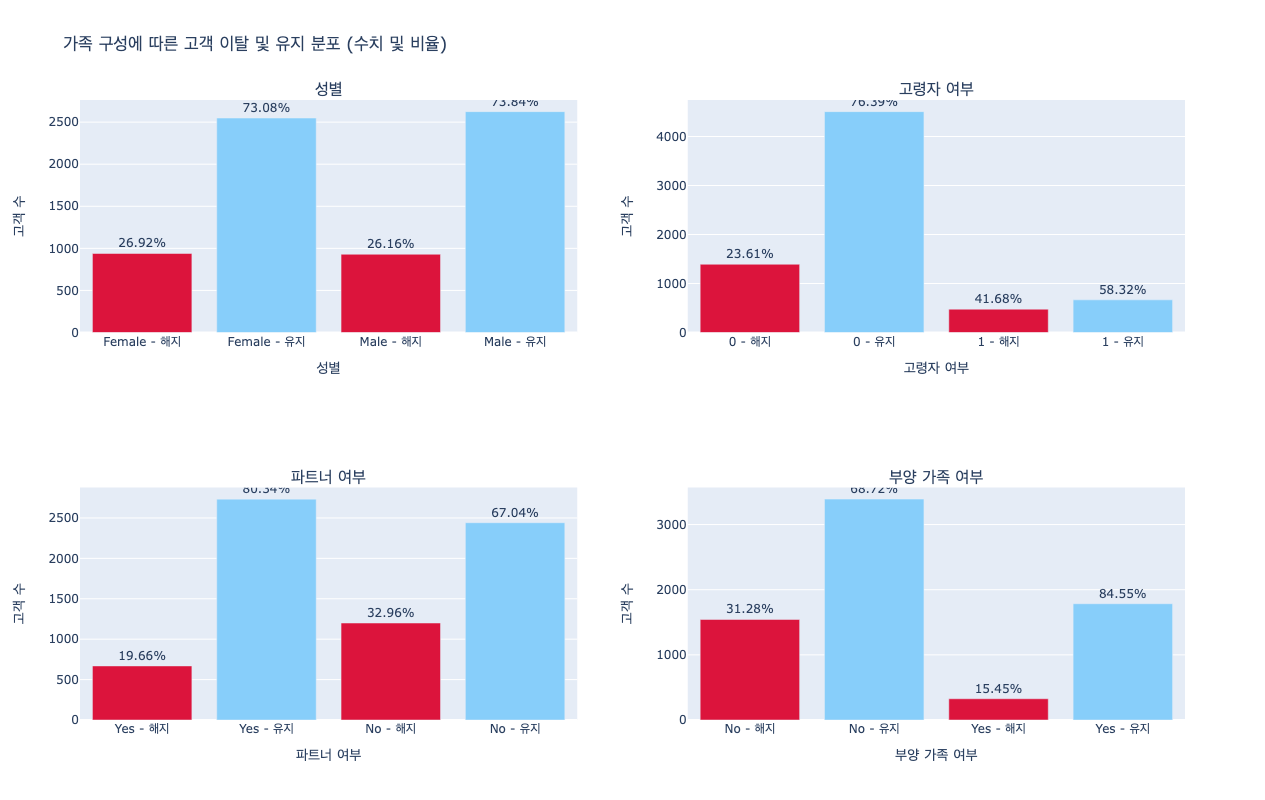

In [12]:
# 성별, 고령자 여부, 파트너 여부, 부양 가족 여부 4개 필드를 churn 여부에 따라 분포를 2x2로 그래프로 표현하되, 각각의 count와 비율로 표기
fig = make_subplots(rows=2, cols=2, subplot_titles=("성별", "고령자 여부", "파트너 여부", "부양 가족 여부"))

fields = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
titles = ['성별', '고령자 여부', '파트너 여부', '부양 가족 여부']
for i, field in enumerate(fields):
    for value in df[field].unique():
        filtered_df = df[df[field] == value]
        churn_yes = filtered_df[filtered_df['Churn'] == 'Yes']
        churn_no = filtered_df[filtered_df['Churn'] == 'No']
        total = len(churn_yes) + len(churn_no)
        yes_percentage = (len(churn_yes) / total) * 100
        no_percentage = (len(churn_no) / total) * 100
        fig.add_trace(go.Bar(x=[f'{value} - 해지'], y=[len(churn_yes)], name='해지', marker_color='crimson', text=f'{yes_percentage:.2f}%'), row=(i//2)+1, col=(i%2)+1)
        fig.add_trace(go.Bar(x=[f'{value} - 유지'], y=[len(churn_no)], name='유지', marker_color='lightskyblue', text=f'{no_percentage:.2f}%'), row=(i//2)+1, col=(i%2)+1)
    fig.update_xaxes(title_text=titles[i], row=(i//2)+1, col=(i%2)+1)
    fig.update_yaxes(title_text="고객 수", row=(i//2)+1, col=(i%2)+1)
fig.update_traces(textposition='outside')
fig.update_layout(barmode='group', title_text='가족 구성에 따른 고객 이탈 및 유지 분포 (수치 및 비율)', height=800, width=1000, showlegend=False)


### 결제 관련 1차 분석 결과 알게된 사실
* 성별과 이탈에는 관계가 없다. (가설: 성별 정보는 정확하지 않을수 있다. 대표가입자의 성별 정보일뿐)
* 나이가 많을 수록 이탈 가능성이 높다. (가설: 나이가 많을수록 가격이나 서비스에 대한 민감도가 높다)
* 파트너가 있는 사람은 이탈 가능성이 낮다. (가설: 연인이 있으면 돈걱정 않하는 경향이 있을수도 있고, 상대방의 취향에 따라 혼자 판단하지 않는다)
* 부양가족이 있는 사람은 이탈 가능성이 낮다. (가설: 가족이 있으면 의사결정이 어려워지고, 가족의 의견을 따르는 경향이 있을수도 있다)

### 추가로 확인해볼사항
* 성별을 제외한 각 항목별 교차분석을 해보자
* 범주형 통계가 유의미한지 확인해보자

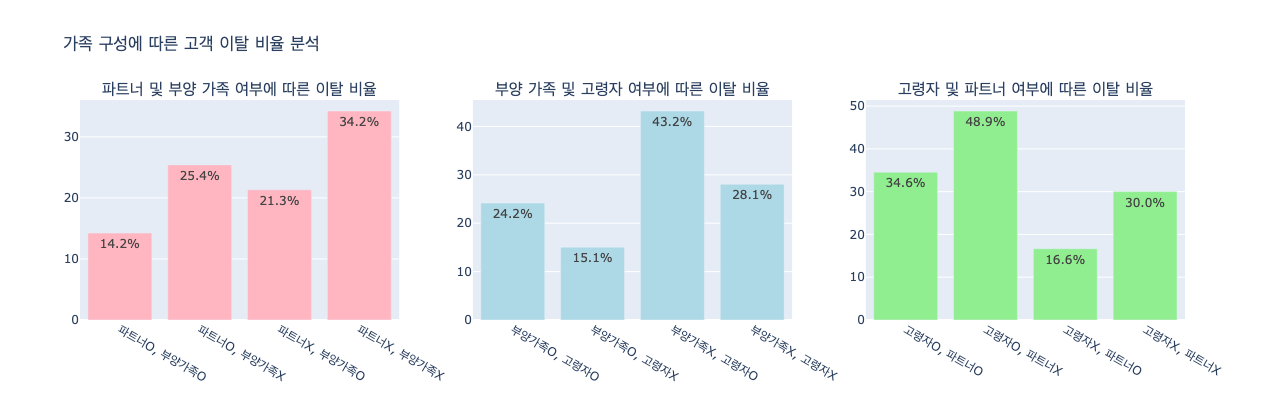

In [13]:
# 파트너와 부양가족 여부에 따른 이탈률 분석
fig = make_subplots(rows=1, cols=3, subplot_titles=("파트너 및 부양 가족 여부에 따른 이탈 비율", "부양 가족 및 고령자 여부에 따른 이탈 비율", "고령자 및 파트너 여부에 따른 이탈 비율"))

# 파트너와 부양가족 여부에 따른 이탈률 분석
df['Partner_Dependents'] = df['Partner'].replace({'Yes': '파트너O', 'No': '파트너X'}) + ', ' + df['Dependents'].replace({'Yes': '부양가족O', 'No': '부양가족X'})
partner_dependents = df.groupby('Partner_Dependents')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
partner_dependents_str = partner_dependents.map('{:0.1f}%'.format)
fig.add_trace(go.Bar(x=partner_dependents.index, y=partner_dependents['Yes'], text=partner_dependents_str['Yes'], name='파트너 및 부양 가족 여부', marker_color='lightpink'), row=1, col=1)

# 부양가족와 고령자 여부에 따른 이탈률 분석
df['Dependents_SeniorCitizen'] = df['Dependents'].replace({'Yes': '부양가족O', 'No': '부양가족X'}) + ', ' + df['SeniorCitizen'].replace({1: '고령자O', 0: '고령자X'})
dependents_senior_citizen = df.groupby('Dependents_SeniorCitizen')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
dependents_senior_citizen_str = dependents_senior_citizen.map('{:0.1f}%'.format)
fig.add_trace(go.Bar(x=dependents_senior_citizen.index, y=dependents_senior_citizen['Yes'], text=dependents_senior_citizen_str['Yes'], name='부양 가족 및 고령자 여부', marker_color='lightblue'), row=1, col=2)

# 고령자 여부와 파트너 여부에 따른 이탈률 분석
df['SeniorCitizen_Partner'] = df['SeniorCitizen'].replace({1: '고령자O', 0: '고령자X'}) + ', ' + df['Partner'].replace({'Yes': '파트너O', 'No': '파트너X'})
senior_citizen_partner = df.groupby('SeniorCitizen_Partner')['Churn'].value_counts(normalize=True).unstack().fillna(0) * 100
senior_citizen_partner_str = senior_citizen_partner.map('{:0.1f}%'.format)
fig.add_trace(go.Bar(x=senior_citizen_partner.index, y=senior_citizen_partner['Yes'], text=senior_citizen_partner_str['Yes'], name='고령자 및 파트너 여부', marker_color='lightgreen'), row=1, col=3)

fig.update_layout(title_text='가족 구성에 따른 고객 이탈 비율 분석', showlegend=False, height=400, width=1500)
fig.show()


In [14]:
# 카이제곱 검정을 통해 파트너, 부양가족, 고령자 여부가 이탈 여부에 영향을 미치는지 확인
from scipy.stats import chi2_contingency

fields = ['Partner', 'Dependents', 'SeniorCitizen']
results = []
for field in fields:
    crosstab = pd.crosstab(df[field], df['Churn'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    results.append([field, chi2, p, dof, expected])
results_df = pd.DataFrame(results, columns=['필드', '카이제곱 통계량', 'p-value', '자유도', '기대값'])
results_df['결과'] = results_df['p-value'].apply(lambda x: '유의함' if x < 0.05 else '유의하지 않음')
results_df


필드    카이제곱 통계량       p-value  자유도  \
0        Partner  158.733382  2.139911e-36    1   
1     Dependents  189.129249  4.924922e-43    1   
2  SeniorCitizen  159.426300  1.510067e-36    1   

                                                 기대값   결과  
0  [[2674.7883004401533, 966.2116995598467], [249...  유의함  
1  [[3623.9304273746984, 1309.0695726253018], [15...  유의함  
2  [[4335.0523924464005, 1565.9476075535993], [83...  유의함

### 결제 관련 2차 분석 결과 알게된 사실
* 파트너 여부에 따른 이탈율 저하보다는 부양가족 여부에 따른 이탈율 저하가 더 크다.  (가설: 함께 사는 사람이 많을수록 이탈하기 쉽지 않다. 가족상품 패키지가 효과가 있을수 있다)

## 서비스관련 탐색

| PhoneService      | object  | 전화 서비스 가입 여부 |
| OnlineSecurity    | object  | 온라인 보안 서비스 가입 여부 |
| OnlineBackup      | object  | 온라인 백업 서비스 가입 여부 |
| DeviceProtection  | object  | 기기 보호 서비스 가입 여부 |
| TechSupport       | object  | 기술 지원 서비스 가입 여부 |
| StreamingTV       | object  | TV 스트리밍 서비스 가입 여부 |
| StreamingMovies   | object  | 영화 스트리밍 서비스 가입 여부 |

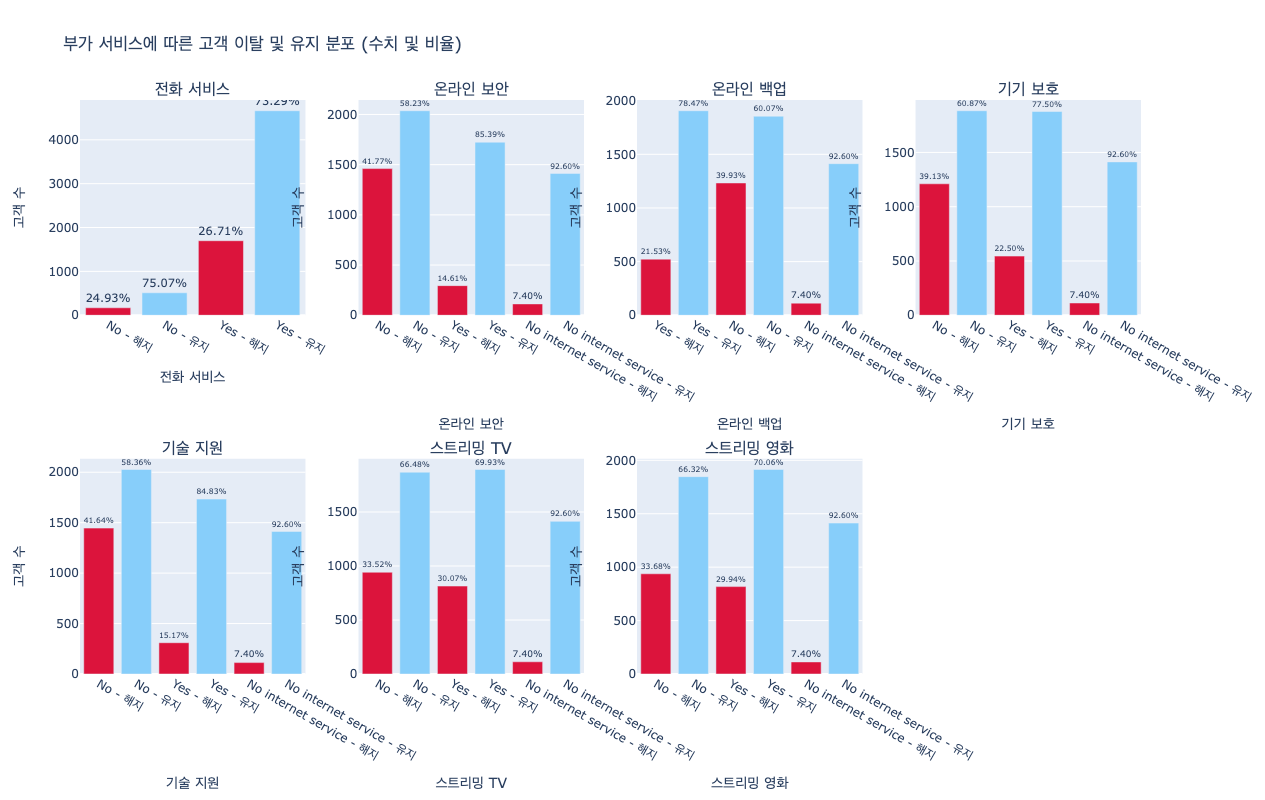

In [15]:
# 전화, 온라인 보안, 온라인 백업, 기기 보호, 기술지원, 스트리밍 TV, 스트리밍 영화 7개 필드를 churn 여부에 따라 분포를 2x4로 그래프로 표현
fig = make_subplots(rows=2, cols=4, subplot_titles=("전화 서비스", "온라인 보안", "온라인 백업", "기기 보호", "기술 지원", "스트리밍 TV", "스트리밍 영화"))

fields = ['PhoneService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
titles = ['전화 서비스', '온라인 보안', '온라인 백업', '기기 보호', '기술 지원', '스트리밍 TV', '스트리밍 영화']

for i, field in enumerate(fields):
    for value in df[field].unique():
        filtered_df = df[df[field] == value]
        churn_yes = filtered_df[filtered_df['Churn'] == 'Yes']
        churn_no = filtered_df[filtered_df['Churn'] == 'No']
        total = len(churn_yes) + len(churn_no)
        yes_percentage = (len(churn_yes) / total) * 100
        no_percentage = (len(churn_no) / total) * 100
        fig.add_trace(go.Bar(x=[f'{value} - 해지'], y=[len(churn_yes)], name='해지', marker_color='crimson', text=f'{yes_percentage:.2f}%'), row=(i//4)+1, col=(i%4)+1)
        fig.add_trace(go.Bar(x=[f'{value} - 유지'], y=[len(churn_no)], name='유지', marker_color='lightskyblue', text=f'{no_percentage:.2f}%'), row=(i//4)+1, col=(i%4)+1)
    fig.update_xaxes(title_text=titles[i], row=(i//4)+1, col=(i%4)+1)
    fig.update_yaxes(title_text="고객 수", row=(i//4)+1, col=(i%4)+1)
fig.update_traces(textposition='outside')
fig.update_layout(barmode='group', title_text='부가 서비스에 따른 고객 이탈 및 유지 분포 (수치 및 비율)', height=800, width=1500, showlegend=False)

fig.show()

### 결제 관련 1차 분석 결과 알게된 사실
* 온라인 보안, 온라인백업, 기기보호, 기술지원 4가지 서비스에 가입한 사람은 이탈 가능성이 낮다. (가설: 애당초 서비스를 추가 신청했다는 사실은 서비스에 만족을 느끼고 있는것으로 해석할수 있다.)
* 추가적인 스트리밍 서비스는 이탈율에 영향을 많이 미치지 않는다. (가설: 스트리밍 서비스는 만족에 의한 가입이 아니라, 패키지 구매였을수 있다.)

## 기타사항 탐색

### 과제 제출 방법
- ipynb 파일을 html로 변환하여 제출해주세요
- e-campus 과제 제출란에 업로드해주세요

### [ #과제1 ]
- 가입기간과 총요금, 월요금을 범주형으로 변환하고, 서비스 가입여부 지표들과 교차분석을 진행해보세요. (가입기간 * 월요금이 총요금이 아닐 수 있다)
- 로열티 높은 고객을 만들기 위한 인사이트를 서술해주세요.
- 마크다운셀을 만들어 내용을 기술해주세요.

### [ #과제2 ]
- MultipleLines ( 다중 회선 사용 여부 ), InternetService ( 인터넷 서비스 종류 ), Contract ( 계약 유형 )
- 3가지 필드에 대한 EDA를 수행하고, 결과를 분석해주세요.
- 시각화 툴은 (plotly, sweetbiz, tableau, pygwalk) 중 선택하여 사용해주세요. (캡처본을 붙여도 됩니다)
- 기초통계량 및 통계검정을 진행해주세요

  

# Part II. AutoML by pyCaret

#### AutoML 특징 및 기능
1) 데이터셋에 대한 전처리를 자동으로 수행
2) 다양한 머신러닝 알고리즘을 활용하여 최적의 모델을 찾아줌
3) 여러 모델을 블렌딩하여 최적의 앙상블 모델을 생성
4) 모델 성능을 평가하고, 모델간 비교를 수행
5) 모델을 저장하고, 로드하여 재사용 가능
6) 모델을 배포할 수 있는 코드를 생성
7) 다양한 시각화 기능을 제공

In [44]:
# pytorch 설치
#!pip3 install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.6/86.6 MB 21.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 24.1 MB/s eta 0:00:0000:0100:01


In [45]:
# lightgbm 설치
#!pip install --no-binary lightgbm --config-settings=cmake.define.USE_OPENMP=OFF 'lightgbm>=4.0.0'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for lightgbm: filename=lightgbm-4.3.0-py3-none-manylinux_2_35_aarch64.whl size=2618895 sha256=c1ae668755aa1a886a479392367a687f19f35479199853e752e824451a25fb9f
  Stored in directory: /home/jovyan/.cache/pip/wheels/f4/d1/f4/3cd66516e5a05b0879846879dfb06e5a087f453adb405a5999
Successfully built lightgbm


In [46]:
# pycaret 설치
#!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.9/485.9 kB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 10.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [66]:
#!pip install scipy==1.11

In [16]:
# 데이터셋을 훈련 데이터와 테스트 데이터로 분리
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [17]:
# pycaret을 사용하여 분류 모델을 학습하기 위한 설정을 자동으로 진행
from pycaret.classification import *
setup_clf = setup(data=train_df, target='Churn')
# ImportError: cannot import name 'interp' from 'scipy' 발생하는 분은 pip scipy==1.11로 설치하고 커널 재시작

* 출력 값 설명
  
| 파라미터 | 값 | 설명 |
| --- | --- | --- |
| 세션 ID | 3088 | 현재 세션의 고유 식별자입니다. |
| 대상(Target) | Churn | 예측하고자 하는 목표 변수입니다. |
| 대상 유형(Target type) | Binary | 목표 변수가 이진 분류임을 나타냅니다. |
| 대상 매핑(Target mapping) | No: 0, Yes: 1 | 'No'와 'Yes'를 각각 0과 1로 매핑합니다. |
| 원본 데이터 형태(Original data shape) | (5634, 21) | 원본 데이터는 5634개의 샘플과 21개의 특성을 가집니다. |
| 변환된 데이터 형태(Transformed data shape) | (5634, 42) | 전처리 후 데이터는 5634개의 샘플과 42개의 특성을 가집니다. |
| 변환된 훈련 세트 형태(Transformed train set shape) | (3943, 42) | 훈련 데이터는 3943개의 샘플과 42개의 특성을 가집니다. |
| 변환된 테스트 세트 형태(Transformed test set shape) | (1691, 42) | 테스트 데이터는 1691개의 샘플과 42개의 특성을 가집니다. |
| 숫자형 특성(Numeric features) | 3 | 숫자형 특성의 개수입니다. |
| 범주형 특성(Categorical features) | 17 | 범주형 특성의 개수입니다. |
| 전처리(Preprocess) | True | 데이터 전처리가 수행되었음을 나타냅니다. |
| 대입 유형(Imputation type) | simple | 단순 대입 방식을 사용했음을 나타냅니다. |
| 숫자형 대입(Numeric imputation) | mean | 숫자형 데이터의 결측치를 평균값으로 대체합니다. |
| 범주형 대입(Categorical imputation) | mode | 범주형 데이터의 결측치를 최빈값으로 대체합니다. |
| 최대 원-핫 인코딩(Maximum one-hot encoding) | 25 | 원-핫 인코딩을 적용할 최대 범주의 수입니다. |
| 인코딩 방법(Encoding method) | None | 특별한 인코딩 방법을 사용하지 않았음을 나타냅니다. |
| 폴드 생성기(Fold Generator) | StratifiedKFold | 계층화 K-폴드 교차 검증을 사용합니다. |
| 폴드 수(Fold Number) | 10 | 교차 검증에 사용할 폴드의 수입니다. |
| CPU 작업(CPU Jobs) | -1 | 사용 가능한 모든 CPU 코어를 사용합니다. |
| GPU 사용(Use GPU) | False | GPU를 사용하지 않음을 나타냅니다. |
| 실험 기록(Log Experiment) | False | 실험을 기록하지 않음을 나타냅니다. |
| 실험 이름(Experiment Name) | clf-default-name | 실험의 이름입니다. |
| USI | 69aa | 고유 세션 식별자입니다. |



## 모델 비교

| 모델 | 설명 |
| --- | --- |
| SVM | 선형 및 비선형 데이터에 대한 다목적 모델. 데이터가 클때는 시간이 많이 걸림. 이탈과 비 이탈 간의 패턴이 복잡할 때 유용 |
| LogReg | 간단하고 해석이 용이한 모델. 이탈 예측과 같은 이진 분류 작업에 적합. 기능이 이탈 가능성에 어떤 영향을 미치는지 파악에 활용가능. |
| RF | 여러 의사결정 트리를 결합하는 앙상블모델. 범주형 및 숫자형을 결합해 처리 가능. 과적합에 잘 버티고 복잡한 데이터셋에 알맞음. |
| GB | 강력한 예측력. 순차 앙상블 모델. 데이터의 복잡한 관계를 포착. 다양한 유형의 데이터셋에 적합. |
| CatBoost | 범주형 변수를 자동으로 처리하는 그래디언트 부스팅 모델. 과적합을 방지하고 정확도를 높임. 빠른 속도와 높은 정확도를 제공. |
| LightGBM | 빠른 속도와 높은 정확도를 제공하는 그래디언트 부스팅 모델. 대용량 데이터셋에 적합. 과적합을 방지하고 정확도를 높임. |
| Stacking | 여러 모델을 조합하여 최적의 모델을 만드는 앙상블 모델. 다양한 모델을 조합하여 정확도를 높임. |

### 모델 리스트
<img src="https://blog.kakaocdn.net/dn/pvnGP/btrybYDos57/Q5WZrDXsEY5Nwl4WJ92sL1/img.png" height=700>

In [18]:
# 단일 모델 생성하기
lightgbm = create_model('lightgbm', fold=3)

\
                                                 
Initiated  . . . . . . . . . . . . . . . . . .   
Status     . . . . . . . . . . . . . . . . . .   
Estimator  . . . . . . . . . . . . . . . . . .   

                                            
                                            
Initiated                         02:36:04  
Status                     Fitting 3 Folds  
Estimator  Light Gradient Boosting Machine

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/pycaret/internal/pipeline.py", line 276, in fit
    fitted_estimator = self._memory_fit(
                       ^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/pycaret/internal/pipeline.py", line 69, in _fit_one
    transformer.fit(*args)
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/sklearn.py", line 1187, in fit
    super().fit(
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Booster = train(
                    ^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/engine.py", line 255, in train
    booster = Booster(params=params, train_set=train_set)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 3433, in __init__
    train_set.construct()
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 2462, in construct
    self._lazy_init(data=self.data, label=self.label, reference=None,
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 2123, in _lazy_init
    return self.set_feature_name(feature_name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 2863, in set_feature_name
    _safe_call(_LIB.LGBM_DatasetSetFeatureNames(
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 263, in _safe_call
    raise LightGBMError(_LIB.LGBM_GetLastError().decode('utf-8'))
lightgbm.basic.LightGBMError: Do not support special JSON characters in feature name.


In [20]:
# 정확도를 기준으로 상위 5개 모델 생성하기
top5 = compare_models(sort='Accuracy', n_select=5)

In [21]:
# 상위 5개 모델을 튜닝하기
tuned_top5 = [tune_model(i) for i in top5]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [21]:
# 앙상블 모델 생성하기
blender_top5 = blend_models(estimator_list=tuned_top5)

Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [22]:
# 최종 모델 생성하기
final_model = finalize_model(blender_top5)

In [25]:
# 테스트 데이터에 대한 예측 결과 생성하기
prediction = predict_model(final_model, data=test_df.drop('Churn', axis=1))

In [29]:
# 테스트셋에 대한 예측 정확도 확인하기
from pycaret.utils.generic import check_metric
check_metric(test_df['Churn'], prediction['prediction_label'], metric = 'Accuracy')

0.7871

# Part III. CometML 과 Optuna 를 활용한 모델 설계 및 하이퍼파라미터 튜닝

### COMET ML 소개
- MLOps
- COMET ML은 머신러닝 실험을 위한 온라인 플랫폼
- 실험을 추적하고, 실험 결과를 시각화하며, 모델을 관리하는데 사용
- https://www.comet.com/

### optuna 패키지 소개
- Optuna는 하이퍼파라미터 최적화를 위한 오픈소스 라이브러리입니다.
- Optuna는 베이즈 최적화를 기반으로 하이퍼파라미터 최적화를 수행합니다.
- Optuna는 다양한 머신러닝 프레임워크와 호환되며, 사용자가 최적화하고자 하는 함수를 정의하면 Optuna가 하이퍼파라미터 최적화를 수행합니다.
- Optuna는 다양한 알고리즘을 제공하며, 사용자가 원하는 알고리즘을 선택하여 최적화를 수행할 수 있습니다.

In [ ]:
#!pip install comet_ml
#!pip install xgboost
#!pip install optuna

In [22]:
import optuna

In [23]:
# XGBClassifier
from xgboost import XGBClassifier
# LightGBM
from lightgbm import LGBMClassifier

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, log_loss

In [25]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model
# 가입 절차 필요 (https://www.comet.com/)

experiment = Experiment(
  api_key="xxxxxxxxxxx",
  project_name="xxxxxxxxxxx",
  workspace="xxxxxxxxxxx"
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, xgboost, lightgbm.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: The given API key xxxxxxxxxxx is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/v2/api-and-sdk/python-sdk/warnings-errors/
COMET ERROR: The given API key xxxxxxxxxxx is invalid on www.comet.com, please check it against the dashboard. Your experiment will not be logged 
For more details, please refer to: https://www.comet.com/docs/v2/api-and-sdk/python-sdk/warnings-errors/


In [31]:
# 앞서 분석한 내용중, 유의미한 특성을 범주형과 수치형, 그리고 타겟으로 나누어 저장
categorical_features = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'PaperlessBilling']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target_variable = 'Churn'

In [52]:
# float 타입으로 변환되지 못하는 행을 처리
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')

In [105]:
# 타겟값 바이너리화
df.Churn = df.Churn.map({'Yes': 1, 'No': 0})

In [106]:
# 원핫 인코더와 스케일러 준비
encoder = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()

In [107]:
# 데이터셋 분리
X_train, X_val, y_train, y_val = train_test_split(df.drop("Churn", axis=1), df["Churn"], test_size=0.2, random_state=42)

In [108]:
# 범주형 인코딩
X_train_encoded = encoder.fit_transform(X_train[categorical_features])
X_val_encoded = encoder.transform(X_val[categorical_features])

In [109]:
# 수치형 스케일링
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_val_scaled = scaler.transform(X_val[numerical_features])

In [110]:
# 인코딩된 범주형 데이터와 스케일링된 수치형 데이터를 합치기
X_train_processed = np.concatenate((X_train_encoded.toarray(), X_train_scaled), axis=1)
X_val_processed = np.concatenate((X_val_encoded.toarray(), X_val_scaled), axis=1)

In [111]:
# NaN 값을 평균으로 채우기
X_train_processed = np.nan_to_num(X_train_processed, nan=np.nanmean(X_train_processed))
X_val_processed = np.nan_to_num(X_val_processed, nan=np.nanmean(X_val_processed))

In [112]:
# 데이터셋 크기 확인
X_train_processed.shape, X_val_processed.shape

((5634, 28), (1409, 28))

#### Optuna 목적함수 작성

In [113]:
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 300),
        'max_depth': trial.suggest_categorical('xgb_max_depth', [3, 4, 5]),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.2),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 5),
    }

    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n_estimators', 100, 300),
        'max_depth': trial.suggest_categorical('lgbm_max_depth', [3, 4, 5]),
        'learning_rate': trial.suggest_float('lgbm_learning_rate', 0.01, 0.2),
    }

    logreg_params = {
        'C': trial.suggest_categorical('logreg_C', [0.1, 1, 10]),
        'solver': trial.suggest_categorical('logreg_solver', ['liblinear', 'lbfgs']),
    }
    
    # 모델 훈련
    xgb = XGBClassifier()
    lgbm = LGBMClassifier()
    logreg = LogisticRegression()
    
    xgb.fit(X_train_processed, y_train)
    lgbm.fit(X_train_processed, y_train)
    logreg.fit(X_train_processed, y_train)
    
    # 검증 데이터에 대한 예측
    xgb_predictions = xgb.predict(X_val_processed)
    lgbm_predictions = lgbm.predict(X_val_processed)
    logreg_predictions = logreg.predict(X_val_processed)
    
    # 검증 데이터에 대한 예측 정확도 계산
    xgb_accuracy = accuracy_score(y_val, xgb_predictions)
    lgbm_accuracy = accuracy_score(y_val, lgbm_predictions)
    logreg_accuracy = accuracy_score(y_val, logreg_predictions)
    
    # 검증 데이터에 대한 예측 ROC AUC 계산
    xgb_roc_auc = roc_auc_score(y_val, xgb.predict_proba(X_val_processed)[:, 1])
    lgbm_roc_auc = roc_auc_score(y_val, lgbm.predict_proba(X_val_processed)[:, 1])
    logreg_roc_auc = roc_auc_score(y_val, logreg.predict_proba(X_val_processed)[:, 1])

    
    
    # StackingClassifier를 사용하여 앙상블 모델 생성
    estimators = [
        ('xgboost', xgb),
        ('lightgbm', lgbm),
        ('logreg', logreg)
    ]
    stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
    stacking_classifier.fit(X_train_processed, y_train)
    
    # StackingClassifier의 검증 데이터에 대한 예측 정확도 계산
    stacking_predictions = stacking_classifier.predict(X_val_processed)
    stacking_accuracy = accuracy_score(y_val, stacking_predictions)
    stacking_roc_auc = roc_auc_score(y_val, stacking_classifier.predict_proba(X_val_processed)[:, 1])
    
    # Comet ML 로 하이퍼파라미터 및 메트릭 기록
    experiment.log_parameters({
        'xgb_n_estimators': xgb_params['n_estimators'],
        'xgb_max_depth': xgb_params['max_depth'],
        'xgb_learning_rate': xgb_params['learning_rate'],
        'xgb_min_child_weight': xgb_params['min_child_weight'],
        'lgbm_n_estimators': lgbm_params['n_estimators'],
        'lgbm_max_depth': lgbm_params['max_depth'],
        'lgbm_learning_rate': lgbm_params['learning_rate'],
        'logreg_C': logreg_params['C'],
        'logreg_solver': logreg_params['solver']
    })
    
    # 정확도 및 ROC AUC 기록
    experiment.log_metrics({
        'xgb_accuracy': xgb_accuracy,
        'lgbm_accuracy': lgbm_accuracy,
        'logreg_accuracy': logreg_accuracy,
        'xgb_roc_auc': xgb_roc_auc,
        'lgbm_roc_auc': lgbm_roc_auc,
        'logreg_roc_auc': logreg_roc_auc,
        'stacking_accuracy': stacking_accuracy,
        'stacking_roc_auc': stacking_roc_auc
    })
    
    # 목적함수를 최소화하기 위해 음수 정확도를 반환합니다
    return -stacking_accuracy

#### Optuna 최적화 수행

In [117]:
from tabulate import tabulate

# 연구 생성 및 최적화
study = optuna.create_study(direction='minimize')  # 최적화 목표에 따라 방향 조정
study.optimize(objective, n_trials=10)  # 시도 횟수 지정

# 최적 하이퍼파라미터 및 결과 가져오기
best_params = study.best_params # 최적의 하이퍼파라미터
best_accuracy = -study.best_value  # 양수 정확도로 변환

# 딕셔너리를 테이블 형식의 키-값 쌍 리스트로 변환
param_table = [(key, value) for key, value in best_params.items()]

# 최적 하이퍼파라미터 테이블 표시
best_params = tabulate(param_table, headers=["매개변수", "값"], tablefmt="grid")

print(f"최적의 RF 하이퍼파라미터:\n{best_params}")
print(f"최고점수의 정확도: {best_accuracy}")



[I 2024-03-23 14:39:18,762] A new study created in memory with name: no-name-48dde86f-b935-443b-9975-4fba285c4804


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:20,529] Trial 0 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 289, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.11310007274185307, 'xgb_min_child_weight': 2, 'lgbm_n_estimators': 108, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.17315216409347092, 'logreg_C': 10, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:22,194] Trial 1 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 181, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.11497924137574389, 'xgb_min_child_weight': 2, 'lgbm_n_estimators': 164, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.051629408338005896, 'logreg_C': 10, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:23,676] Trial 2 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 299, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.11832949539445875, 'xgb_min_child_weight': 1, 'lgbm_n_estimators': 239, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.17386204102019537, 'logreg_C': 1, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:25,361] Trial 3 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 104, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.039864730005539396, 'xgb_min_child_weight': 4, 'lgbm_n_estimators': 201, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.17346345489135762, 'logreg_C': 1, 'logreg_solver': 'liblinear'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:26,983] Trial 4 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 221, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.14120100853328604, 'xgb_min_child_weight': 3, 'lgbm_n_estimators': 192, 'lgbm_max_depth': 4, 'lgbm_learning_rate': 0.19793185053401466, 'logreg_C': 10, 'logreg_solver': 'liblinear'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:28,631] Trial 5 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 157, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.19274806446252854, 'xgb_min_child_weight': 5, 'lgbm_n_estimators': 271, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.07742259252859435, 'logreg_C': 10, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:30,595] Trial 6 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 156, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.05557898597341011, 'xgb_min_child_weight': 4, 'lgbm_n_estimators': 233, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.11640023097146408, 'logreg_C': 1, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:32,134] Trial 7 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 210, 'xgb_max_depth': 3, 'xgb_learning_rate': 0.16470497624297425, 'xgb_min_child_weight': 3, 'lgbm_n_estimators': 215, 'lgbm_max_depth': 3, 'lgbm_learning_rate': 0.18185313048828747, 'logreg_C': 0.1, 'logreg_solver': 'lbfgs'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:33,691] Trial 8 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 278, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.03450748354662812, 'xgb_min_child_weight': 1, 'lgbm_n_estimators': 268, 'lgbm_max_depth': 4, 'lgbm_learning_rate': 0.12698875525646755, 'logreg_C': 1, 'logreg_solver': 'liblinear'}. Best is trial 0 with value: -0.8161816891412349.


[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265531 -> initscore=-1.017418
[LightGBM] [Info] Start training from score -1.017418
[LightGBM] [Info] Number of positive: 1496, number of negative: 4138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 634
[LightGBM] [Info] Number of data points in the train set: 5634, number of used features: 28
[LightGBM] [Info] [binary:

[I 2024-03-23 14:39:35,112] Trial 9 finished with value: -0.8161816891412349 and parameters: {'xgb_n_estimators': 279, 'xgb_max_depth': 4, 'xgb_learning_rate': 0.06479006304285251, 'xgb_min_child_weight': 4, 'lgbm_n_estimators': 265, 'lgbm_max_depth': 5, 'lgbm_learning_rate': 0.19488134064090432, 'logreg_C': 0.1, 'logreg_solver': 'liblinear'}. Best is trial 0 with value: -0.8161816891412349.


최적의 RF 하이퍼파라미터:
+----------------------+---------------------+
| 매개변수             | 값                  |
+======================+=====================+
| xgb_n_estimators     | 289                 |
+----------------------+---------------------+
| xgb_max_depth        | 4                   |
+----------------------+---------------------+
| xgb_learning_rate    | 0.11310007274185307 |
+----------------------+---------------------+
| xgb_min_child_weight | 2                   |
+----------------------+---------------------+
| lgbm_n_estimators    | 108                 |
+----------------------+---------------------+
| lgbm_max_depth       | 3                   |
+----------------------+---------------------+
| lgbm_learning_rate   | 0.17315216409347092 |
+----------------------+---------------------+
| logreg_C             | 10                  |
+----------------------+---------------------+
| logreg_solver        | lbfgs               |
+----------------------+---------------------+
최고

In [116]:
# 딕셔너리를 사용하여 여러 하이퍼파라미터 보고:
hyper_params = {
   
   "learning_rate": 0.5,
   "steps": 100000,
   "batch_size": 50,
}
experiment.log_parameters(hyper_params)


#### 결과확인은 COMET ML을 통해 확인